In [65]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import pandas as pd

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [66]:
train_path = './rsna-2024-lumbar-spine-degenerative-classification/'

train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

In [67]:
test_desc.head()

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [68]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [69]:
train_desc.head()

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [70]:
# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_desc, f'{train_path}/train_images')
test_image_paths = generate_image_paths(test_desc, f'{train_path}/test_images')

In [71]:
# Print only the first 10 items in the list
for item in train_image_paths[:2]:
    print(f"{item}\n")


./rsna-2024-lumbar-spine-degenerative-classification//train_images\4003253\702807833\1.dcm

./rsna-2024-lumbar-spine-degenerative-classification//train_images\4003253\702807833\10.dcm


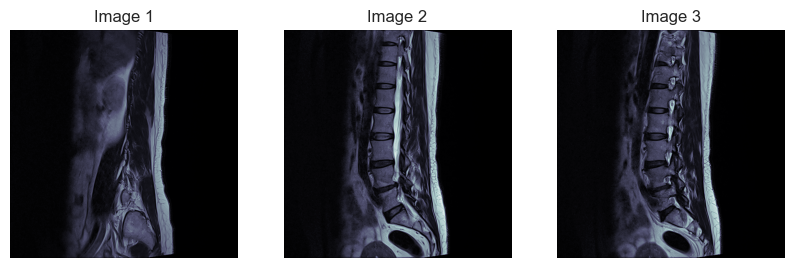

In [72]:
import pydicom
import matplotlib.pyplot as plt

# Function to open and display DICOM images
def display_dicom_images(image_paths,amount):
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    for i, path in enumerate(image_paths[:amount]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, amount, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Image {i+1}")
        plt.axis('off')
        
    plt.show()

# Display the first three DICOM images
display_dicom_images(train_image_paths,3)

Processing path: ./rsna-2024-lumbar-spine-degenerative-classification/train_images\100206310\1012284084\1.dcm
Processing path: ./rsna-2024-lumbar-spine-degenerative-classification/train_images\100206310\1792451510\1.dcm
Processing path: ./rsna-2024-lumbar-spine-degenerative-classification/train_images\100206310\2092806862\1.dcm


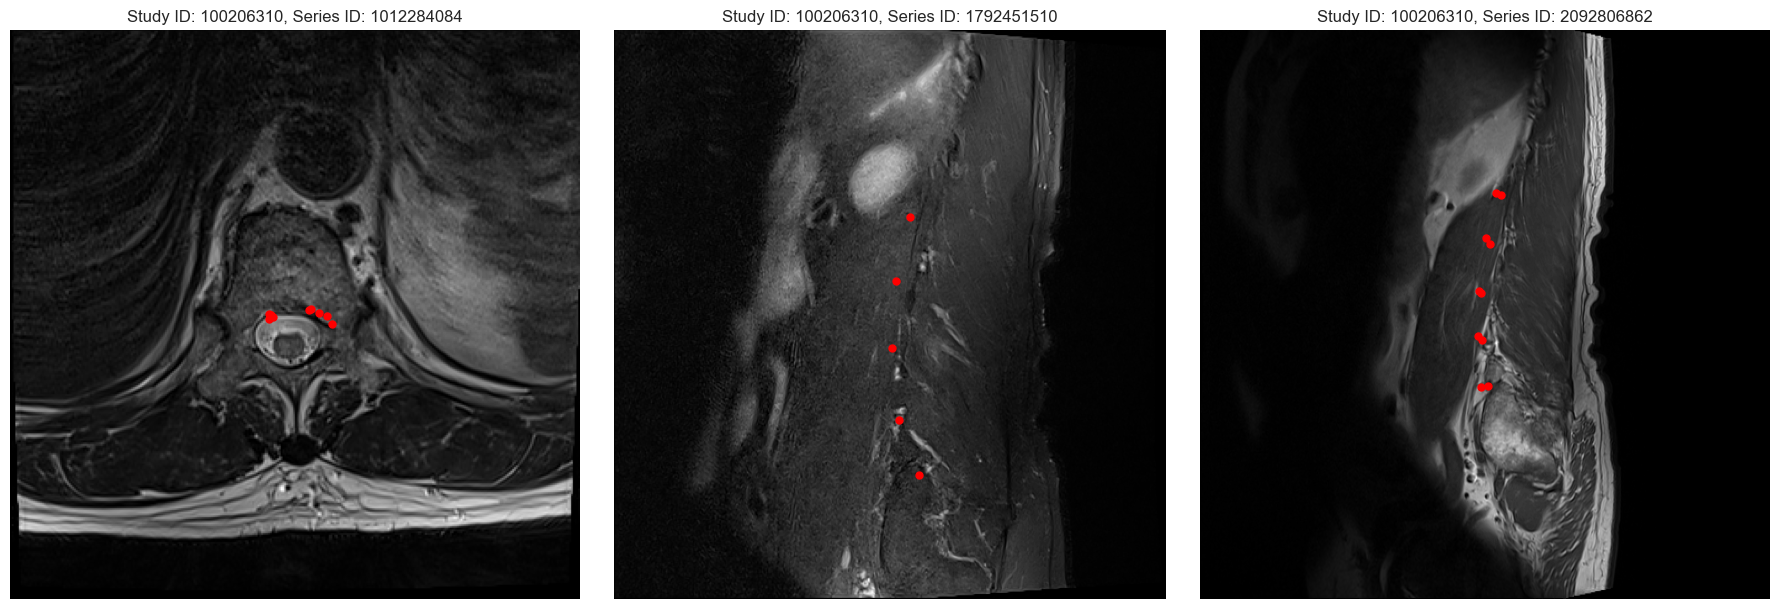

In [73]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd

def display_dicom_with_coordinates(image_paths, label_df):
    fig, axs = plt.subplots(1, len(image_paths), figsize=(18, 6))
    
    for idx, path in enumerate(image_paths):  # Display images
        print(f"Processing path: {path}")
        
        try:
            study_id = int(os.path.basename(os.path.dirname(os.path.dirname(path))))
            series_id = int(os.path.basename(os.path.dirname(path)))
        except (ValueError, IndexError) as e:
            print(f"Error processing path: {path}, Error: {e}")
            continue  # Skip this path and move to the next one
        
        # Filter label coordinates for the current study and series
        filtered_labels = label_df[(label_df['study_id'] == study_id) & (label_df['series_id'] == series_id)]
        
        # Read DICOM image
        ds = pydicom.dcmread(path)
        
        # Plot DICOM image
        axs[idx].imshow(ds.pixel_array, cmap='gray')
        axs[idx].set_title(f"Study ID: {study_id}, Series ID: {series_id}")
        axs[idx].axis('off')
        
        # Plot coordinates
        for _, row in filtered_labels.iterrows():
            axs[idx].plot(row['x'], row['y'], 'ro', markersize=5)
        
    plt.tight_layout()
    plt.show()

# Load DICOM files from a folder
def load_dicom_files(path_to_folder):
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
    return files

# Display DICOM images with coordinates
train_path = './rsna-2024-lumbar-spine-degenerative-classification/'

study_id = "100206310"
study_folder = os.path.join(train_path, 'train_images', study_id)

image_paths = []
for series_folder in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_folder)
    dicom_files = load_dicom_files(series_folder_path)
    if dicom_files:
        image_paths.append(dicom_files[0])  # Add the first image from each series
        

display_dicom_with_coordinates(image_paths, label)

In [74]:
label.head(10)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
5,4003253,1054713880,4,Right Neural Foraminal Narrowing,L4/L5,187.961759,251.839388
6,4003253,1054713880,4,Right Neural Foraminal Narrowing,L5/S1,198.240918,285.613767
7,4003253,1054713880,5,Right Neural Foraminal Narrowing,L3/L4,187.227533,210.722753
8,4003253,1054713880,6,Right Neural Foraminal Narrowing,L1/L2,194.569790,127.755258
9,4003253,1054713880,6,Right Neural Foraminal Narrowing,L2/L3,191.632887,165.934990


In [75]:
sub.head()

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.333333,0.333333,0.333333
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.333333,0.333333,0.333333
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.333333,0.333333,0.333333
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.333333,0.333333,0.333333
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.333333,0.333333,0.333333


In [76]:
# Define function to reshape a single row of the DataFrame
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows of the reshaped dataframe
new_train_df.head(30)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild


In [77]:
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
# Display the first few rows of the final merged dataframe
final_merged_df.head(20)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,11,196.070671,126.021201,Sagittal T1
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,1054713880,12,191.321555,170.120141,Sagittal T1
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,1054713880,12,187.878354,217.245081,Sagittal T1
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate,1054713880,11,186.504472,251.592129,Sagittal T1
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,1054713880,11,197.100569,289.457306,Sagittal T1


In [78]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(final_merged_df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pydicom
from sklearn.model_selection import train_test_split

# Define the base directory where your DICOM files are stored
base_dir = 'rsna-2024-lumbar-spine-degenerative-classification/train_images/'

# Create a dictionary to keep track of the count of instances for each 'study_id' + 'series_id'
instance_count = {}

# Function to create the image path and update the instance count
def construct_image_path(row, base_dir, instance_count):
    key = f"{row['study_id']}/{row['series_id']}"
    
    # Special handling for specific directories
    if key == "208289456/4140564625" or key == "3324678907/1935317419" or key == "3369277408/890756726":
        if key not in instance_count:
            instance_count[key] = -1  # Start at -1 so the first increment gives 1
        instance_count[key] += 2  # Increment by 2 for odd numbering
    elif key == "3303545110/304087230":
        if key not in instance_count:
            instance_count[key] = 31  # Start at 31 so the first increment gives 32
        instance_count[key] += 1  # Increment by 1 for normal numbering
    elif key == "2794192602/1829533928" or "642715533/3541751675":
        if key not in instance_count:
            instance_count[key] = 1  # Start at 1 so the first increment gives 2
        instance_count[key] += 1  # Increment by 1 for normal numbering
    else:
        if key not in instance_count:
            instance_count[key] = 1
        else:
            instance_count[key] += 1
    
    instance_number = instance_count[key]
    image_path = os.path.join(base_dir, f"{row['study_id']}/{row['series_id']}/{instance_number}.dcm")
    return image_path, instance_number

# Apply the function to each row and create the 'image_path' and 'instance_number' columns
final_merged_df['image_path'], final_merged_df['instance_number'] = zip(*final_merged_df.apply(
    lambda row: construct_image_path(row, base_dir, instance_count), axis=1))

# Verify the updated image paths
final_merged_df.head(20)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,2,322.831858,227.964602,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,3,320.571429,295.714286,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,4,323.030303,371.818182,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,5,335.292035,427.327434,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,6,353.415929,483.964602,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,2,196.070671,126.021201,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,1054713880,3,191.321555,170.120141,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,1054713880,4,187.878354,217.245081,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate,1054713880,5,186.504472,251.592129,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,1054713880,6,197.100569,289.457306,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...


In [ ]:
import os
import pandas as pd
import pydicom
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the dataframe into training, validation, and test sets
train_df, test_df = train_test_split(final_merged_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Define the mapping from severity labels to numerical values
severity_mapping = {
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2  # Adjusted to match the number of classes (0, 1, 2)
}

# Apply the mapping to your DataFrame
train_df['severity'] = train_df['severity'].map(severity_mapping)
val_df['severity'] = val_df['severity'].map(severity_mapping)
test_df['severity'] = test_df['severity'].map(severity_mapping)

# Check for NaNs in the 'severity' column
nan_rows_train = train_df[train_df['severity'].isna()]
nan_rows_val = val_df[val_df['severity'].isna()]
nan_rows_test = test_df[test_df['severity'].isna()]

print(f"Number of rows with NaN values in the training set: {len(nan_rows_train)}")
print(f"Number of rows with NaN values in the validation set: {len(nan_rows_val)}")
print(f"Number of rows with NaN values in the test set: {len(nan_rows_test)}")

# Drop rows with NaN values in the 'severity' column
train_df = train_df.dropna(subset=['severity'])
val_df = val_df.dropna(subset=['severity'])
test_df = test_df.dropna(subset=['severity'])

# Verify there are no NaNs remaining
assert not train_df['severity'].isnull().any(), "NaN values found in training labels"
assert not val_df['severity'].isnull().any(), "NaN values found in validation labels"
assert not test_df['severity'].isnull().any(), "NaN values found in test labels"
assert train_df['severity'].isin([0, 1, 2]).all(), "Unexpected values found in training labels"
assert val_df['severity'].isin([0, 1, 2]).all(), "Unexpected values found in validation labels"
assert test_df['severity'].isin([0, 1, 2]).all(), "Unexpected values found in test labels"

print("No NaN values found after dropping NaNs.")

# Define the custom dataset
class SpineDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        ds = pydicom.dcmread(image_path)
        image = ds.pixel_array

        # Normalize to the range 0-255 and convert to uint8
        image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        image = image.astype(np.uint8)
        image = Image.fromarray(image)

        # Convert grayscale image to RGB by duplicating the channels
        image = image.convert("RGB")

        label = row['severity']  # Numerical severity label

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset and dataloaders
train_dataset = SpineDataset(train_df, transform=transform)
val_dataset = SpineDataset(val_df, transform=transform)
test_dataset = SpineDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ResNet model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust the final layer to match the number of classes
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation functions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()  # Ensure labels are LongTensor

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= total_train
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()  # Ensure labels are LongTensor

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= total_val
        val_acc = correct_val / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
num_epochs = 25
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.tight_layout()
plt.show()


Number of rows with NaN values in the training set: 26
Number of rows with NaN values in the validation set: 2
Number of rows with NaN values in the test set: 7
No NaN values found after dropping NaNs.


In [ ]:
import pandas as pd

# Example prediction DataFrame (replace this with your actual prediction DataFrame)
# Assuming the 'final_merged_df' has columns 'study_id', 'condition', 'level', and 'predicted_severity'
# This is a mockup DataFrame to illustrate
predictions = {
    'study_id': [44036939] * 25,
    'condition': [
        'spinal_canal_stenosis', 'spinal_canal_stenosis', 'spinal_canal_stenosis', 'spinal_canal_stenosis', 'spinal_canal_stenosis',
        'left_neural_foraminal_narrowing', 'left_neural_foraminal_narrowing', 'left_neural_foraminal_narrowing', 'left_neural_foraminal_narrowing', 'left_neural_foraminal_narrowing',
        'right_neural_foraminal_narrowing', 'right_neural_foraminal_narrowing', 'right_neural_foraminal_narrowing', 'right_neural_foraminal_narrowing', 'right_neural_foraminal_narrowing',
        'left_subarticular_stenosis', 'left_subarticular_stenosis', 'left_subarticular_stenosis', 'left_subarticular_stenosis', 'left_subarticular_stenosis',
        'right_subarticular_stenosis', 'right_subarticular_stenosis', 'right_subarticular_stenosis', 'right_subarticular_stenosis', 'right_subarticular_stenosis'
    ],
    'level': [
        'l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1',
        'l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1',
        'l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1',
        'l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1',
        'l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1'
    ],
    'normal_mild': [0.3333333333333333] * 25,  # Example probabilities
    'moderate': [0.3333333333333333] * 25,
    'severe': [0.3333333333333333] * 25
}

# Convert the dictionary to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Create the 'row_id' column by combining 'study_id', 'condition', and 'level'
predictions_df['row_id'] = predictions_df.apply(lambda row: f"{row['study_id']}_{row['condition']}_{row['level']}", axis=1)

# Select only the necessary columns
submission_df = predictions_df[['row_id', 'normal_mild', 'moderate', 'severe']]

# Save the DataFrame to CSV
submission_path = '/mnt/data/submission.csv'
submission_df.to_csv(submission_path, index=False)

# Display the path to the saved file
print(f"Submission file saved as {submission_path}")
